In [5]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
# import tensorflow as tf
# import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

sns.set("talk")

In [7]:
ratingDFX3 = pd.read_pickle("/content/drive/MyDrive/오픈소스 SW/ratingReducedPickle.pkl")

# 中身確認
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)
"""
Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213
"""

ratingDFX3.head()

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:5026,1,1
1,49,163,3.5,2013-05-03 02:4337,2,1
2,49,216,3.0,2013-05-03 02:4558,3,1
3,49,296,5.0,2013-05-03 02:5013,4,1
4,49,333,3.0,2013-05-03 02:4438,5,1


In [8]:
# 訓練データと学習データの切り分け
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)

X_validation, X_test = train_test_split(X_test, test_size=0.50, \
                                        shuffle=True, random_state=2018)


In [9]:
#格付け行列を作成する、ほとんどがゼロのスパース行列となる
ratings_train = np.zeros((n_users,n_movies))
for row in X_train.itertuples():
  ratings_train[row[6]-1,row[5]-1] = row[3]

ratings_train.shape
#(1000,1000)

# 検証データの格付け行列
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

#検証データをフラット化
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [10]:
#予測値を3.5としたときの二乗誤差(MSE)を検証セットに対して計算
#これをベースラインとする

pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5

print("3.5 MSE:",mean_squared_error(pred_validation,actual_validation))
#3.5 MSE: 1.055420084238528

3.5 MSE: 1.055420084238528


In [11]:
#行列分解
#ユーザとアイテムの次元を減らして圧縮する

n_latent_factors = 3 #潜在因子、何次元に埋め込むか

#kerasで圧縮されたユーザ列の作成
user_input = Input(shape=[1], name="user")
user_embedding = Embedding(input_dim=n_users+1, output_dim=n_latent_factors,name="user_embedding")(user_input)
user_vec = Flatten(name="flatten_users")(user_embedding)

#kerasで圧縮された映画列の作成
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)


product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=30, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)


Epoch 1/30
2538/2538 [==============================] - 8s 3ms/step - loss: 12.4375 - val_loss: 8.2194
Epoch 2/30
2538/2538 [==============================] - 9s 4ms/step - loss: 4.6380 - val_loss: 2.6114
Epoch 3/30
2538/2538 [==============================] - 7s 3ms/step - loss: 1.8152 - val_loss: 1.3851
Epoch 4/30
2538/2538 [==============================] - 6s 2ms/step - loss: 1.0893 - val_loss: 1.0002
Epoch 5/30
2538/2538 [==============================] - 5s 2ms/step - loss: 0.8564 - val_loss: 0.8744
Epoch 6/30
2538/2538 [==============================] - 5s 2ms/step - loss: 0.7785 - val_loss: 0.8257
Epoch 7/30
2538/2538 [==============================] - 5s 2ms/step - loss: 0.7519 - val_loss: 0.8094
Epoch 8/30
2538/2538 [==============================] - 5s 2ms/step - loss: 0.7419 - val_loss: 0.8085
Epoch 9/30
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7382 - val_loss: 0.8039
Epoch 10/30
2538/2538 [==============================] - 6s 2ms/step - loss: 0.73

Minimum MSE:  0.7937151193618774


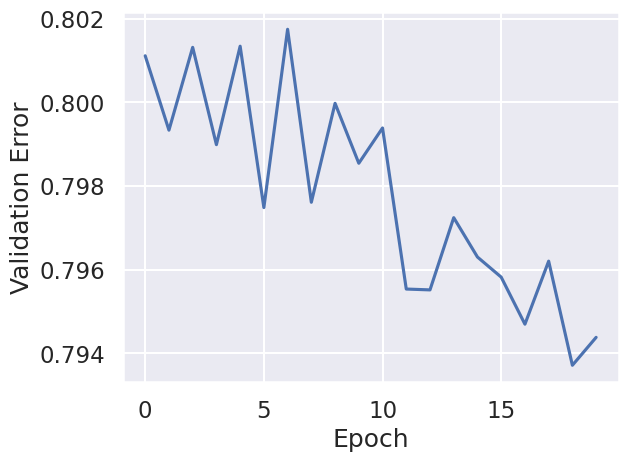

In [12]:

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))
#Minimum MSE:  0.7946764826774597
